# Abalone dataset analysis for later modelling

Start by adding all the libraries and imports

In [2]:
# Global imports
import sys
import math
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from dataclasses import dataclass
# User defined files
from split_dataset import split_dataset
from model_accuracy import model_accuracy
from scale_data import scale_data
from kernel import kernel_linear
from kernel import kernel_poly
from kernel import kernel_rbf
from save_model import *
# Ignore warnings
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')

None



Load dataset


In [3]:
# Start dataset analysis
abalone = pd.read_csv('abalone.csv', skipinitialspace=True)
abalone.columns = abalone.columns.str.replace(' ','')

## Feature data visualization

Let's see how is the feature data on a friendly way. The table shows the features and their categorical or numerical values.

In [4]:
abalone.columns=['Sex','Length','Diameter','Height','Whole weight', 'Shucked weight','Viscera weight','Shell weight','Rings']
abalone.sample(10)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1005,M,0.605,0.475,0.155,1.1610,0.5720,0.2455,0.2750,9
2223,F,0.555,0.455,0.180,0.9580,0.2960,0.1950,0.3900,14
1329,I,0.570,0.450,0.135,0.7940,0.3815,0.1415,0.2450,8
2750,I,0.510,0.385,0.145,0.7665,0.3985,0.1400,0.1805,8
3697,M,0.650,0.510,0.175,1.1550,0.4955,0.2025,0.3850,12
581,I,0.550,0.425,0.150,0.8060,0.3760,0.1710,0.2450,14
3627,M,0.715,0.525,0.200,1.8900,0.9500,0.4360,0.4305,10
1713,M,0.645,0.500,0.175,1.3375,0.5540,0.3080,0.4150,10
592,I,0.525,0.410,0.175,0.8740,0.3585,0.2070,0.2050,18
3725,M,0.495,0.375,0.155,0.9760,0.4500,0.2285,0.2475,9



Plot dataset data. This is usefull to have an insight about the data and how it is related with the features. The categorical feature 'Sex' is hidden


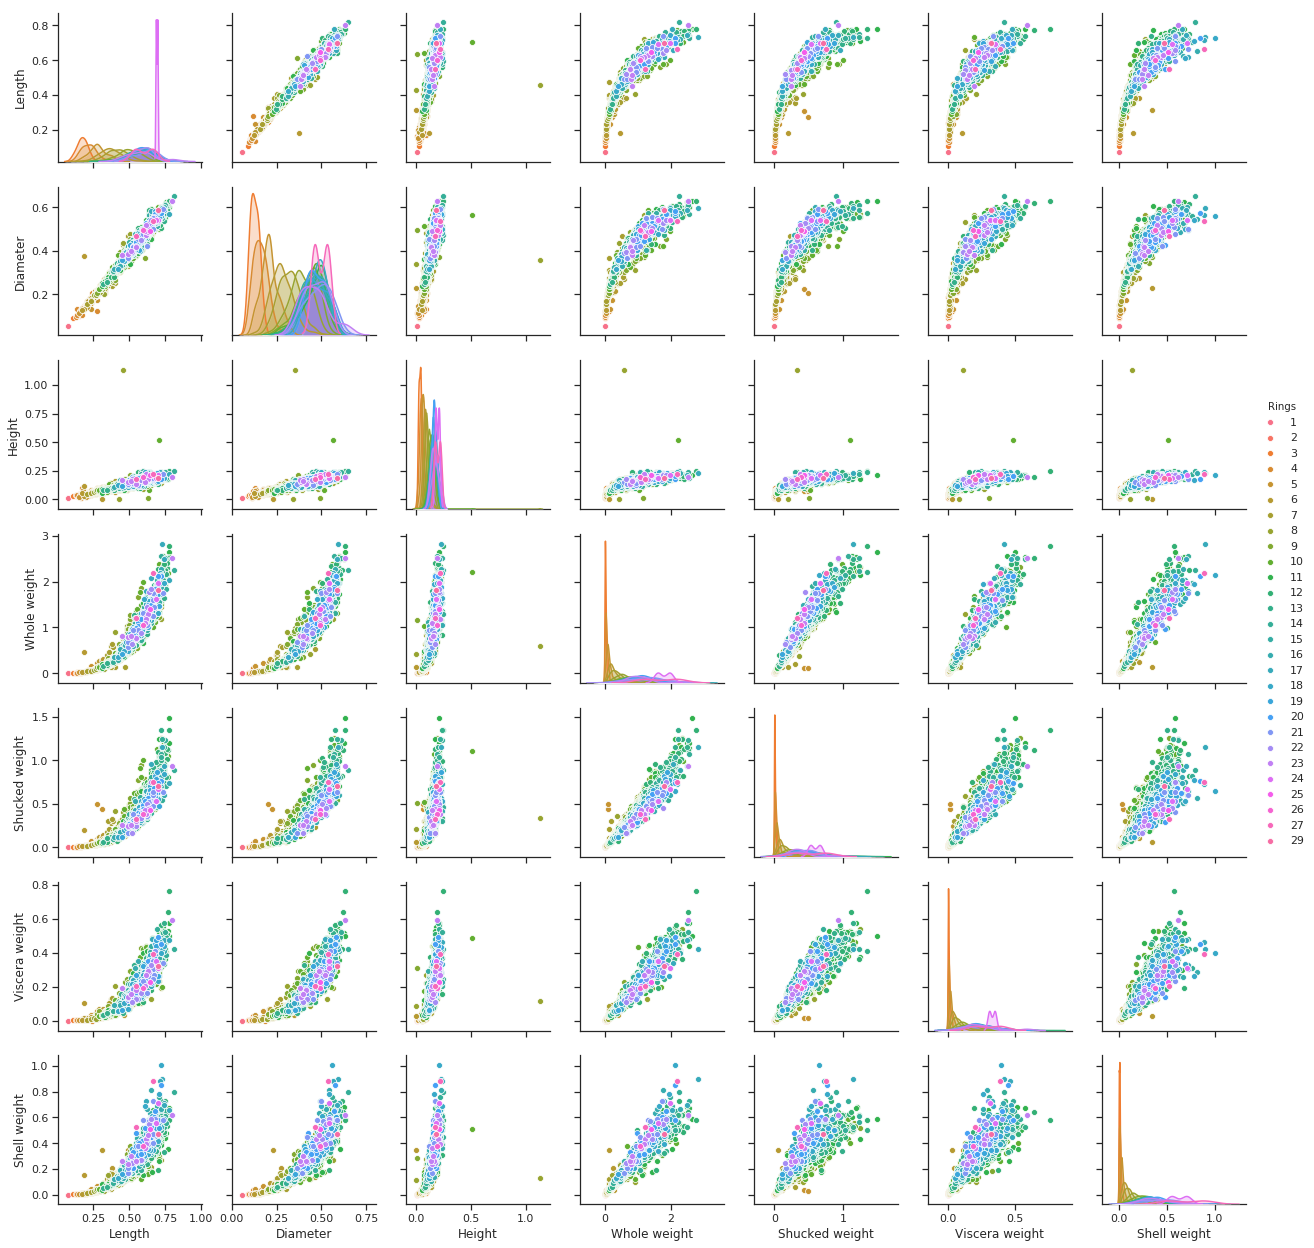

In [5]:
# Plot all data into subsets
sns.set(style="ticks", color_codes=True)
sns.pairplot(abalone, vars=abalone.columns[1:-1],hue='Rings')
plt.show()


As seen on the plots above:

- Length and diameter are linearly correlated
- Height presents some values of 0
- Height has some outliers (above 0.4) that can affected skewness, they should be removed
- Viscera weight has some outliers above 0.6
- Shell weight has outliers near 1
- Whole weight has outliers near 2.75
- Shucked weight has outliers near 1.3
Diameter outliers will not be removed since this column will not be used. It will be explained later on the correlation section.



Let's remove the outliers mentioned above and have a small peek on the features again


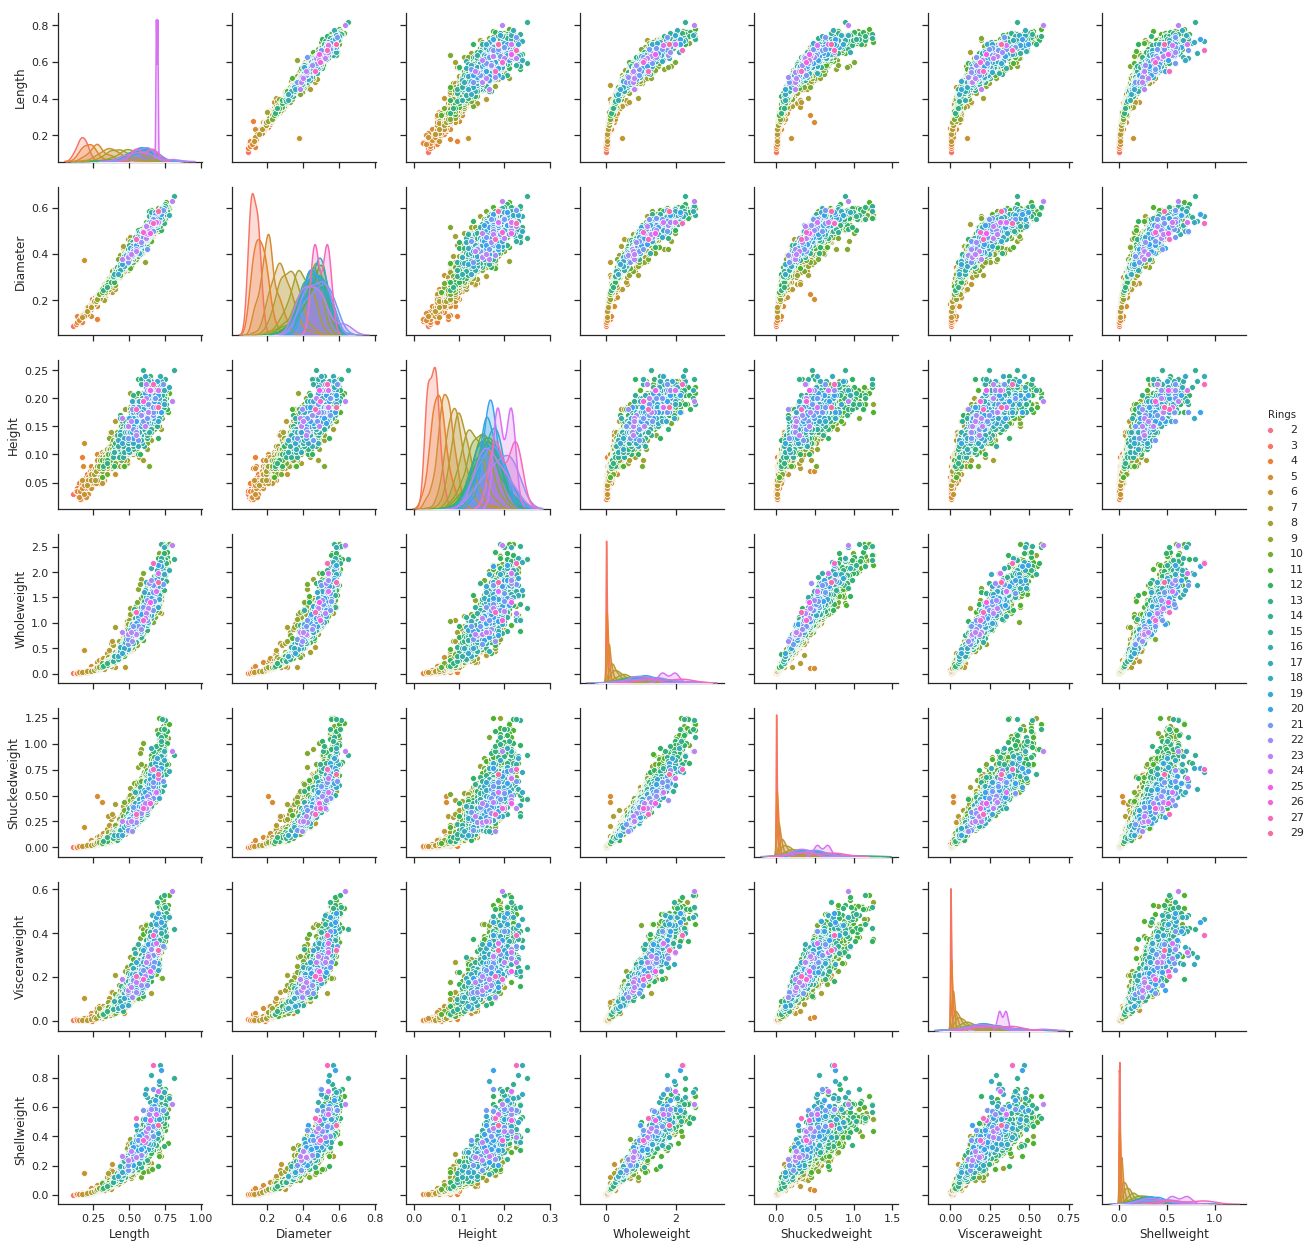

In [6]:
# Clean data that has 0.0 height and the outliers that may cause skewness
abalone.columns = abalone.columns.str.replace(' ','')
abalone = abalone[abalone.Height > 0]
abalone = abalone[abalone.Height < 0.4]
abalone = abalone[abalone.Height > 0.019]
abalone = abalone[abalone.Visceraweight < 0.6]
abalone = abalone[abalone.Shellweight < 1]
abalone = abalone[abalone.Wholeweight < 2.75]
abalone = abalone[abalone.Shuckedweight < 1.3]
# Plot all data into subsets
sns.set(style="ticks", color_codes=True)
sns.pairplot(abalone, vars=abalone.columns[1:-1],hue='Rings')
plt.show()

Now the plots look a bit better since the outliers were removed. It is expected that this changes improved the skewness which will be calculated later.

## Data skewness

In [7]:
# Check dataset skewness
nf = abalone.select_dtypes(include=[np.number]).columns
skew_list = stats.skew(abalone[nf])
skew_list_df = pd.concat([pd.DataFrame(nf,columns=['Features']),pd.DataFrame(skew_list,columns=['Skewness'])],axis = 1)
skew_list_df.sort_values(by='Skewness', ascending = False)

,Features,Skewness
7,Rings,1.123030
4,Shuckedweight,0.657267
6,Shellweight,0.571436
5,Visceraweight,0.550859
3,Wholeweight,0.493013
2,Height,-0.244004
1,Diameter,-0.610091
0,Length,-0.638368


This values of skewness are workable. It will surely have negative effect on training phase but it can be neglected.
Now, feature correlation will be analyzed more in-depth by correlation matrix. It can be seen also in the scatter plots, but the matrix gives us a numeric grade of each feature and how it correlates with the others.

## Correlation matrix

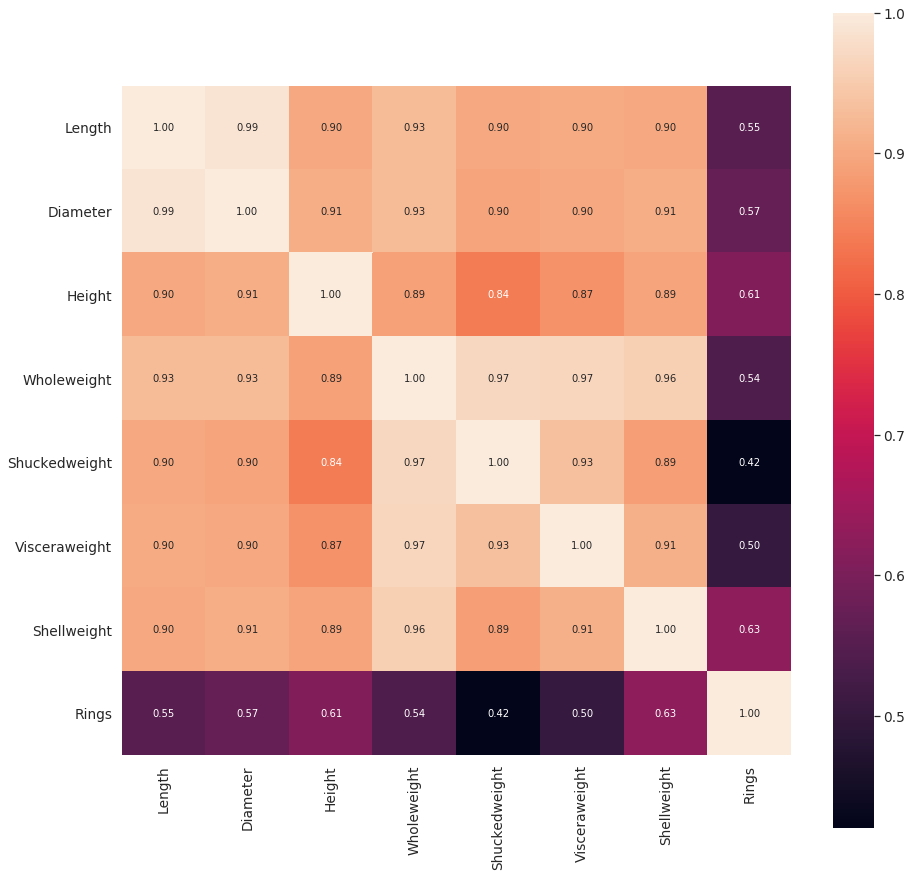

In [8]:
# Correlation matrix
corrmat = abalone.corr()
cols = corrmat.nlargest(8, 'Rings')['Rings'].index
cm = np.corrcoef(abalone[nf].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(15,15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=nf.values, xticklabels=nf.values)
plt.show()

As seen on the matrix above:
- Whole weight is almost linearly correlated with all the features except Rings
- Length and diameter are linear correlated, validation what was observed on the scatter plots
- From all the features excluding rings, height is least correlated with other features

Feature correlation can have negative effect on the modelling phase so it should be dealt with after this type of analysis. The easiest way is to delete or eliminate one of the perfectly correlated features. Another way is to use a dimension reduction algorithm such as Principle Component Analysis (PCA).
As mentioned before, diamter will not be used since it has linear correlation with Length. Also Whole weight, Viscera weight and Shucked weight will not be used since they have very high correlation between them.

## Classification and reduction

For classification, the labels will be binary: Young and Old where Young goes to 9 rings while Old will cover the rest of them. The labels are the rings while the features are all the dataset features except Rings, Sex and Diamater. Diameter was dropped due to the fact that it is linearly correlated with Height. All the data was scaled using Standardization since it provides the best results. Training and testing data were split in a 80/20 ratio.

In [9]:
# Categorize Rings feature into young (0) and adult (1)
abalone['Rings'] = pd.cut(abalone['Rings'], [0,9,abalone['Rings'].max()], labels = [0,1])
# Split dataset for classification
y = abalone['Rings']
print('Label distribuition: ', np.unique(y, return_counts=True))
X = abalone.drop(['Rings', 'Sex', 'Diameter', 'Wholeweight', 'Visceraweight', 'Shuckedweight'], axis = 1)
X = scale_data(X, type_of_scale = 'Standard')
X_train, X_test, y_train, y_test = split_dataset(X, y, 0.20)

Label distribuition:  (array([0, 1]), array([2090, 2074]))


### Linear kernel
As the data is ready, the model can be trained. The first training and reduction will be the Linear kernel. The C parameter value for the best accuracy is 1.

In [10]:
# Let's train
svmParams = {'kernel': 'linear', 'C': 1}
svmModel = svm.SVC(kernel=svmParams['kernel'], C=svmParams['C'])
svmModel.fit(X_train, y_train)
#print('Parameters after fit: ', svmModel.best_params_)    
print('Dual coef matrix: ', svmModel.dual_coef_.shape)
print('Support vector matrix: ', svmModel.support_vectors_.shape)

Dual coef matrix:  (1, 1782)
Support vector matrix:  (1782, 3)


Check how the model performs

In [11]:
# Evaluate model accuracy
cross_score = cross_val_score(svmModel, X_train, y_train, cv=5)
print('Cross score: ', cross_score)
# Infer about the test data using scikit-learn built in predict function
y_pred = np.array(svmModel.predict(X_test))
y_test = np.array(y_test)
accuracy, recall, precision = model_accuracy(y_test, y_pred)
F1 = 2 * (precision * recall) / (precision + recall)
print('Model accuracy and F1 score: ', accuracy, F1)

Cross score:  [0.7946027  0.77927928 0.74024024 0.77627628 0.75375375]
Model accuracy and F1 score:  0.7815126050420168 0.7903225806451614


This kernel provided an accuracy of 78.2% with a F1 score of 79%.
For this kernel, the first size reducion can be made at the model atribute level. This includes the Support Vectors, Alphas, Bias and also the values to test, or input features. After reducing the mentioned values decimal places to 3, the accuracy maintained the same as the F1 score. On this point, the overhead of the values was reduced since the model accuracy maintained even when the value precision was lowered.

In [12]:
# Size reduction to ease deployment on FPGA
svmModel.support_vectors_ = np.around(svmModel.support_vectors_, decimals=3)
svmModel.intercept_ = np.around(svmModel.intercept_, decimals=3)
X_test = np.around(X_test, decimals=3)
y_pred = np.array(svmModel.predict(X_test))
y_test = np.array(y_test)
accuracy, recall, precision = model_accuracy(y_test, y_pred)
F1 = 2 * (precision * recall) / (precision + recall)
print('Model accuracy and F1 score: ', accuracy, F1)

Model accuracy and F1 score:  0.7815126050420168 0.7893518518518517


Next step is to apply size reduction on calculation level. To do this, the Linear kernel function was implemented manually, since the mid-calculations of the Scikit-learn 'predict' function can not be acessed.
The idea here is to simulate that the Kernel * Alpha calculations will be made in hardware. This calculations can not be made in float values since the implementation is easier for 16 bit integers. The kernel calculations have the following format:
 - [-2.617 -2.783 -2.982 ... -2.197 -2.7   -2.918]. 
 
As it can be seen, the values precision is very important since this is the decimal places that change the most. To mitigate the precision issue, Fixed-Point arithmetic will be used. The values will be multiplied by a power of 10 scaling factor (SCALING_FACTOR) and the calculations will be made in 16 bit integer type. For the scaling factor, it needs to be chosen in a way that the calculations will not overflow.
In a nutshell, the kernel calculations result will be scaled by SCALING_FACTOR and converted to 16 bit integer. After that, it is multiplied by the Alpha values and the result is divided by the SCALING_FACTOR to restore decimal presision.

In [13]:
# Size reduction to ease deployment on FPGA
SV = np.float16(np.around(svmModel.support_vectors_, decimals=3))
Alphas = svmModel.dual_coef_
Bias = np.float16(np.around(svmModel.intercept_, decimals=3))
X_test = np.float16(np.around(X_test, decimals=3))
# Evaluate models performance with different manually implemented kernels
# Linear Kernel
y_pred_looped = kernel_linear(SV, Alphas, Bias, X_test)
accuracy, recall, precision = model_accuracy(y_test, y_pred_looped)
F1 = 2 * (precision * recall) / (precision + recall)
print('Model accuracy and F1: ', accuracy, F1)


def kernel_linear(SV, Alphas, Bias, X_test):

    SCALING_FACTOR = 1000
    print('Alpha.K(x,x) - Linear')
    y_pred_looped = []
    for i in range(0, len(X_test)):
        result = np.int16(np.float16(np.dot(SV, X_test[i])) * SCALING_FACTOR)  # This is done in SW
        result = np.int16(np.dot(Alphas, result)) # This is done in HW
        result = result / SCALING_FACTOR  
        result = result + Bias
        if result > 0:
            y_pred_looped.append(1)
        else:
            y_pred_looped.append(0)
    return np.array(y_pred_looped)

Alpha.K(x,x) - Linear
Model accuracy and F1:  0.7827130852340937 0.7897793263646924


Regarding the results, they are better than expected. The new accuracy is 78% with a F1 score of 78.7%. This means that the accuracy was only reduced in 0.2%!

### Polynomial kernel

For the Polynomial kernel the best parameters are a C and Gamma value of 1 and Degree value of 3.

In [14]:
svmParams = {'kernel': 'poly', 'C': 1, 'gamma': 1, 'degree': 3, 'coeff0': 1}
svmModel = svm.SVC(kernel=svmParams['kernel'], C=svmParams['C'], gamma=svmParams['gamma'], degree=svmParams['degree'], coef0=svmParams['coeff0'])
svmModel.fit(X_train, y_train)
#print('Parameters after fit: ', svmModel.best_params_)    
print('Dual coef matrix: ', svmModel.dual_coef_.shape)
print('Support vector matrix: ', svmModel.support_vectors_.shape)

Dual coef matrix:  (1, 1663)
Support vector matrix:  (1663, 3)


Check how the model performs

In [15]:
# Evaluate model accuracy
cross_score = cross_val_score(svmModel, X_train, y_train, cv=5)
print('Cross score: ', cross_score)
# Infer about the test data using scikit-learn built in predict function
y_pred = np.array(svmModel.predict(X_test))
y_test = np.array(y_test)
accuracy, recall, precision = model_accuracy(y_test, y_pred)
F1 = 2 * (precision * recall) / (precision + recall)
print('Model accuracy and F1 score: ', accuracy, F1)

Cross score:  [0.7976012  0.78378378 0.75975976 0.78978979 0.76276276]
Model accuracy and F1 score:  0.7779111644657863 0.7678795483061479


The model provided an accuracy of 77.8% with a F1 score of 76.8%. Similiarly to the Linear kernel, the size reduction will be implemented at atribute level. In this kernels, calculations need more precision than the Linear kernel since it has a power value.

In [16]:
# Infer about the test data using scikit-learn built in predict function
svmModel.support_vectors_ = np.around(svmModel.support_vectors_, decimals=3)
svmModel.intercept_ = np.around(svmModel.intercept_, decimals=3)
X_test = np.around(X_test, decimals=3)
y_pred = np.array(svmModel.predict(X_test))
y_test = np.array(y_test)
accuracy, recall, precision = model_accuracy(y_test, y_pred)
F1 = 2 * (precision * recall) / (precision + recall)
print('Model accuracy and F1 score: ', accuracy, F1)

Model accuracy and F1 score:  0.7767106842737095 0.7680798004987531


Using different decimal places the accuracy of the iterations were:
- For 2 decimal places: 39% (38.8% loss)
- For 3 decimal places: 77.7% (0.1% loss)
- For 4 decimal places: 77.7% (0.1% loss)

For this case, we will leave the values with 3 decimal places. As done in the Linear kernel, the calculations made in hardware will be tested in integer type with a scaling factor. To test this, the kernel was implemented manually.

In [17]:
# Size reduction to ease deployment on FPGA
SV = np.float16(np.around(svmModel.support_vectors_, decimals=3))
Alphas = svmModel.dual_coef_
Bias = np.float16(np.around(svmModel.intercept_, decimals=3))
X_test = np.float16(np.around(X_test, decimals=3))

# Poly Kernel
y_pred_looped = kernel_poly(SV, Alphas, Bias, svmParams['gamma'], svmParams['degree'], svmParams['coeff0'], X_test)
accuracy, recall, precision = model_accuracy(y_test, y_pred_looped)
F1 = 2 * (precision * recall) / (precision + recall)
print('Model accuracy and F1: ', accuracy, F1)

# On this next kernels: Gamma = 1 / Sigma^2
def kernel_poly(SV, Alphas, Bias, Gamma, Degree, Coeff, X_test):
    SCALING_FACTOR = 10
    print('Alpha.K(x,x) - Poly')
    y_pred_looped = []
    for i in range(0, len(X_test)):
        result = np.float32(np.dot(SV, X_test[i]) * Gamma)
        result = np.int16(np.float32((Coeff + result)**Degree) * SCALING_FACTOR)
        result = np.int16(np.dot(Alphas, result))
        result = result / SCALING_FACTOR
        result = result + Bias
        if result > 0:
            y_pred_looped.append(1)
        else:
            y_pred_looped.append(0) 
    return np.array(y_pred_looped)

Alpha.K(x,x) - Poly
Model accuracy and F1:  0.6218487394957983 0.6694648478488983


Performance degradates fast when 16 bit floats are used. With float 32, values remain the same as machine float values. Simulating the hardware component using 16 bit integers and scaling factor of 10, the accuracy is considerably reduced. For the initial 77.8% accuracy, the reduced size accuracy is 65,8%, this means a 12% accuracy decrease.

### RBF kernel

For the RBF kernel the best parameters are a C=1 and Gamma=3.

In [18]:
svmParams = {'kernel': 'rbf', 'C': 1, 'gamma': 3}
svmModel = svm.SVC(kernel=svmParams['kernel'], C=svmParams['C'], gamma=svmParams['gamma'])
svmModel.fit(X_train, y_train) 
print('Dual coef matrix: ', svmModel.dual_coef_.shape)
print('Support vector matrix: ', svmModel.support_vectors_.shape)

Dual coef matrix:  (1, 1704)
Support vector matrix:  (1704, 3)


Model performance

In [19]:
# Evaluate model accuracy
cross_score = cross_val_score(svmModel, X_train, y_train, cv=5)
print('Cross score: ', cross_score)
# Infer about the test data using scikit-learn built in predict function
y_pred = np.array(svmModel.predict(X_test))
y_test = np.array(y_test)
accuracy, recall, precision = model_accuracy(y_test, y_pred)
F1 = 2 * (precision * recall) / (precision + recall)
print('Model accuracy and F1 score: ', accuracy, F1)

Cross score:  [0.80209895 0.78678679 0.75975976 0.78528529 0.76876877]
Model accuracy and F1 score:  0.7815126050420168 0.7848699763593381


The model presented an accuracy of 78.3% with a F1 score of 78.2%. Much like the polynomial kernel, 3 decimal places will be used since it presents to accuracy decrease.

Size reduction regarding integer type presented good results. The accuracy mainted when using 16 bit integer type with a scaling factor of 100.

In [20]:
# Size reduction to ease deployment on FPGA
SV = np.float16(np.around(svmModel.support_vectors_, decimals=3))
Alphas = np.float16(svmModel.dual_coef_)
Bias = np.float16(np.around(svmModel.intercept_, decimals=3))
X_test = np.float16(np.around(X_test, decimals=3))

# RBF Kernel
y_pred_looped = kernel_rbf(SV, Alphas, Bias, svmParams['gamma'], X_test)
accuracy, recall, precision = model_accuracy(y_test, y_pred_looped)
F1 = 2 * (precision * recall) / (precision + recall)
print('Model accuracy and F1: ', accuracy, F1)

def kernel_rbf(SV, Alphas, Bias, Gamma, X_test):

    SCALING_FACTOR = 100
    print('Alpha.K(x,x) - RBF')
    y_pred_looped = []

    for i in range(0, len(X_test)):
        result = np.float16(euclidean_distances(SV, X_test[i].reshape(1, -1),  squared=True)) # SW
        result = np.float16(np.exp(-Gamma * result)) # SW
        result = np.int16(result * SCALING_FACTOR)
        result = np.int16(np.dot(Alphas, result))
        result = result / SCALING_FACTOR
        result = result + Bias
        if result > 0:
            y_pred_looped.append(1)
        else:
            y_pred_looped.append(0)
    return np.array(y_pred_looped)

Alpha.K(x,x) - RBF
Model accuracy and F1:  0.7827130852340937 0.7857988165680474


### Data export method

To export the parameter values of the trained models, a text file will be used. Into this file, will be written:
- Support vectors
- Alpha (Lagrange Multipliers)
- Bias
- Gamma (for polynomial and rbf kernel)
- Degree (for polynomial kernel)

This values will be written in the order presented in the listing above.

In [21]:
def save_model_linear(SV, Alphas, Bias):

    with open('linear.out', 'a') as f:
        dataToWrite = SV
        np.savetxt(f, dataToWrite,'%5.3f', delimiter=',')
        f.write("EOP\n")
        dataToWrite = Alphas.transpose()
        np.savetxt(f, dataToWrite, '%5.3f', delimiter=',')
        f.write("EOP\n")
        dataToWrite = Bias
        np.savetxt(f, dataToWrite,'%5.3f', delimiter=',')
        f.write("EOP\n")

def save_model_poly (SV, Alphas, Bias, Gamma, Degree):
    
    with open('poly.out', 'a') as f:
        dataToWrite = SV
        np.savetxt(f, dataToWrite,'%5.3f', delimiter=',')
        f.write("EOP\n")
        dataToWrite = Alphas.transpose()
        np.savetxt(f, dataToWrite, '%5.3f', delimiter=',')
        f.write("EOP\n")
        dataToWrite = Bias
        np.savetxt(f, dataToWrite,'%5.3f', delimiter=',')
        f.write("EOP\n")
        f.write(str(Gamma) + "\n")
        f.write("EOP\n")
        f.write(str(Degree) + "\n")
        f.write("EOP\n")

def save_model_rbf (SV, Alphas, Bias, Gamma):

    with open('rbf.out', 'a') as f:
        dataToWrite = SV
        np.savetxt(f, dataToWrite,'%5.3f', delimiter=',')
        f.write("EOP\n")
        dataToWrite = Alphas.transpose()
        np.savetxt(f, dataToWrite, '%5.3f', delimiter=',')
        f.write("EOP\n")
        dataToWrite	 = Bias
        np.savetxt(f, dataToWrite,'%5.3f', delimiter=',')
        f.write("EOP\n")
        f.write(str(Gamma) + "\n")
        f.write("EOP\n")